---
author: Zeel B Patel
badges: true
categories: NumPy, Mathematics
description: Bayesian Gaussian Basis Regression
title: Bayesian Gaussian Basis Regression
date: '2023-08-31'
toc: true
---

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import regdata as rd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

from tqdm import tqdm

import matplotlib.pyplot as plt

device = "cuda"
rd.set_backend("torch")


## Generate data

torch.Size([94, 2]) torch.Size([94])
torch.float32 torch.float32


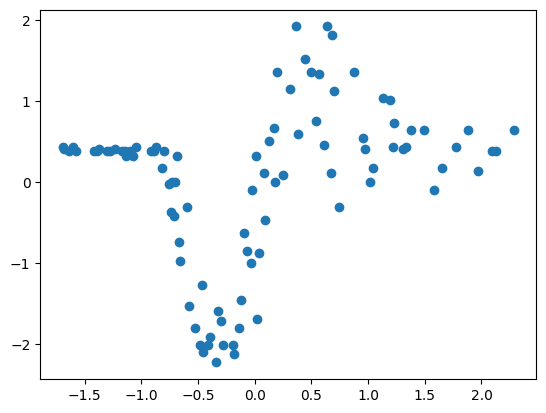

In [2]:
# x = torch.linspace(-1, 1, 100)
# y = (torch.sin(x * 2 * torch.pi) + torch.randn(x.size()) * 0.1).unsqueeze(1)
x, y, _ = rd.MotorcycleHelmet().get_data()
x = x.ravel().to(torch.float32)
idx = np.argsort(x)
x = x[idx]
y = y.to(torch.float32)
y = y[idx]

x = torch.vstack([torch.ones_like(x), x]).T
print(x.shape, y.shape)
x = x.to(device)
y = y.to(device)
print(x.dtype, y.dtype)

plt.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())


In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, neurons, transform=None):
        super().__init__()
        self.layers = nn.ModuleList()
        self.transform = transform
        if transform is None:
            self.transform = lambda x: x
            self.layers.append(nn.Linear(in_dim, neurons[0]))
        else:
            self.layers.append(nn.Linear(self.transform.n_grid + 1, neurons[0]))
        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))
        self.layers.append(nn.Linear(neurons[-1], out_dim))

    def forward(self, x):
        x = self.transform(x)
        # print(x.shape)
        for layer in self.layers[:-1]:
            x = F.gelu(layer(x))
        return self.layers[-1](x)


class GaussianBasis(nn.Module):
    def __init__(self, log_gauss_var, n_grid):
        super().__init__()
        self.log_gauss_var = nn.Parameter(torch.tensor(log_gauss_var))
        self.n_grid = n_grid
        self.grid = nn.Parameter(torch.linspace(-1, 1, n_grid))
        self.register_buffer("bias", torch.zeros(1))

    def forward(self, x):
        self.dist = dist.Normal(self.grid, torch.exp(self.log_gauss_var))
        features = torch.exp(self.dist.log_prob(x[:, 1:2]))
        # print(features.shape)
        features = torch.cat(
            [
                torch.ones_like(self.bias.repeat(features.shape[0])).reshape(-1, 1),
                features,
            ],
            dim=1,
        )
        return features


In [4]:
GaussianBasis(0.0, 10).to(device)(x).shape

torch.Size([94, 11])

In [5]:
# def transform_fn(x):
#     all_x = []
#     for i in range(2, 11):
#         all_x.append(x[:, 1:2] ** i)
#     return torch.hstack([x] + all_x)


def get_mn_sn(x, s0):
    x = transform_fn(x)
    sn_inv = (x.T @ x) / torch.exp(log_var_noise)
    diag = sn_inv.diagonal()
    diag += 1 / s0
    sn = torch.inverse(sn_inv)
    mn = sn @ ((x.T @ y) / torch.exp(log_var_noise))
    return mn, sn


def neg_log_likelihood(x, y, m0, s0):
    x = transform_fn(x)
    cov = (x @ x.T) / s0
    diag = cov.diagonal()
    diag += torch.exp(log_var_noise)
    return (
        -dist.MultivariateNormal(m0.repeat(y.shape[0]), cov).log_prob(y.ravel()).sum()
    )


def get_pred_post(sn, mn, x):
    x = transform_fn(x)
    pred_cov = x @ sn @ x.T
    diag = pred_cov.diagonal()
    diag += torch.exp(log_var_noise)
    pred_mean = x @ mn
    return pred_mean, pred_cov


def plot_preds_and_95(ax, x, pred_mean, pred_cov):
    with torch.no_grad():
        x = x[:, 1].cpu().numpy()
        pred_mean = pred_mean.ravel().cpu().numpy()
        pred_var = pred_cov.diagonal().cpu().numpy()
        ax.plot(x, pred_mean, color="red", label="mean")
        ax.fill_between(
            x,
            (pred_mean - 2 * np.sqrt(pred_var)),
            (pred_mean + 2 * np.sqrt(pred_var)),
            color="red",
            alpha=0.2,
            label="95% CI",
        )
        return ax

In [6]:
mlp = MLP(2, 1, [256, 256, 256]).to(device)
# mlp = GaussianBasis(0.1, 20).to(device)
transform_fn = mlp.forward

m0 = torch.zeros((1,)).to(device)
s0 = torch.tensor(1.0).to(device)
with torch.no_grad():
    log_var_noise = nn.Parameter(torch.tensor(0.1)).to(device)
    log_var_noise.requires_grad = True
    m0.requires_grad = False
    s0.requires_grad = True


loss: 31.7007: 100%|██████████| 500/500 [00:02<00:00, 188.05it/s]


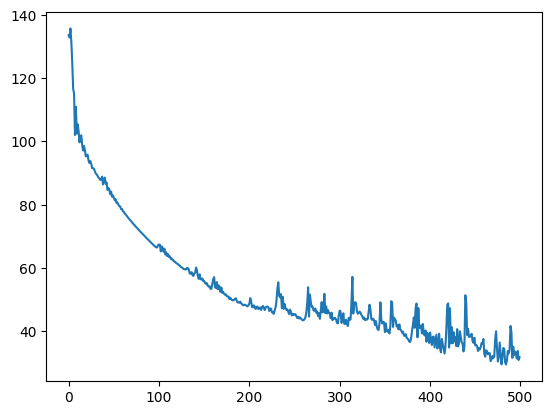

In [7]:
optimizer = torch.optim.Adam([*list(mlp.parameters()), log_var_noise, m0, s0], lr=0.01)
losses = []
pbar = tqdm(range(500))
for i in pbar:
    optimizer.zero_grad()
    loss = neg_log_likelihood(x, y, m0, s0)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

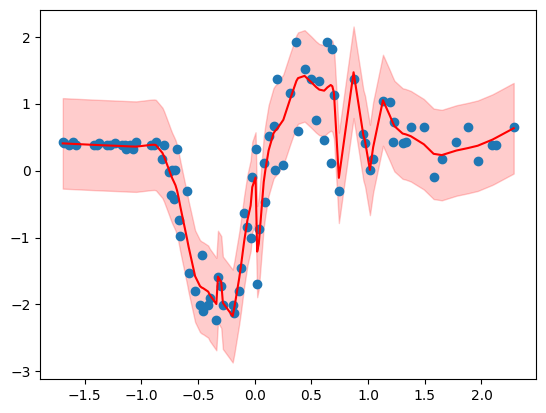

In [8]:
mn, sn = get_mn_sn(x, s0)
pred_mean, pred_var = get_pred_post(sn, mn, x)

fig, ax = plt.subplots()
ax = plot_preds_and_95(ax, x, pred_mean, pred_var)
with torch.no_grad():
    ax.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())
    # ax.vlines(mlp.transform.grid.cpu().numpy(), -1, 1, color="black", alpha=0.2)
plt.show()


In [9]:
torch.exp(log_var_noise), s0


(tensor(0.1141, device='cuda:0', grad_fn=<ExpBackward0>),
 tensor(1.4852, device='cuda:0', requires_grad=True))

## Add Gaussian transform

In [10]:
mlp = MLP(2, 1, [256, 256, 256], transform=GaussianBasis(0.1, 10)).to(device)
# mlp = GaussianBasis(0.1, 20).to(device)
transform_fn = mlp.forward

m0 = torch.zeros((1,)).to(device)
s0 = torch.tensor(1.0).to(device)
with torch.no_grad():
    log_var_noise = nn.Parameter(torch.tensor(0.1)).to(device)
    log_var_noise.requires_grad = True
    m0.requires_grad = False
    s0.requires_grad = True


loss: 55.5719: 100%|██████████| 500/500 [00:03<00:00, 155.48it/s] 


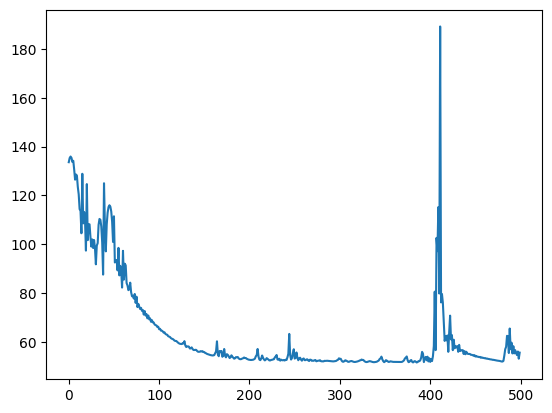

In [11]:
optimizer = torch.optim.Adam([*list(mlp.parameters()), log_var_noise, m0, s0], lr=0.01)
losses = []
pbar = tqdm(range(500))
for i in pbar:
    optimizer.zero_grad()
    loss = neg_log_likelihood(x, y, m0, s0)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

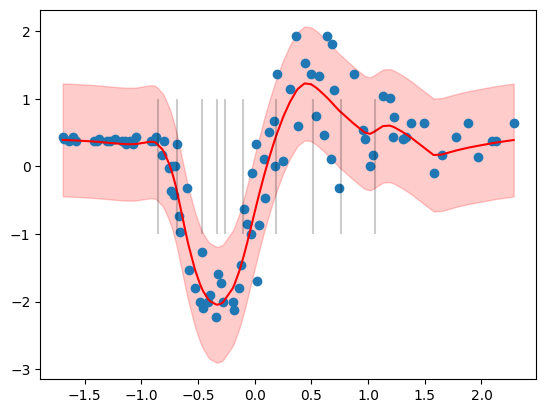

In [12]:
mn, sn = get_mn_sn(x, s0)
pred_mean, pred_var = get_pred_post(sn, mn, x)

fig, ax = plt.subplots()
ax = plot_preds_and_95(ax, x, pred_mean, pred_var)
with torch.no_grad():
    ax.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())
    ax.vlines(mlp.transform.grid.cpu().numpy(), -1, 1, color="black", alpha=0.2)
plt.show()


## Just Gaussian basis

In [13]:
# mlp = MLP(2, 1, [32, 32, 32], transform=GaussianBasis(0.1, 10)).to(device)
mlp = GaussianBasis(0.1, 20).to(device)
transform_fn = mlp.forward

m0 = torch.zeros((1,)).to(device)
s0 = torch.tensor(1.0).to(device)
with torch.no_grad():
    log_var_noise = nn.Parameter(torch.tensor(0.1)).to(device)
    log_var_noise.requires_grad = True
    m0.requires_grad = False
    s0.requires_grad = True


loss: 59.5425: 100%|██████████| 5000/5000 [00:26<00:00, 189.36it/s]


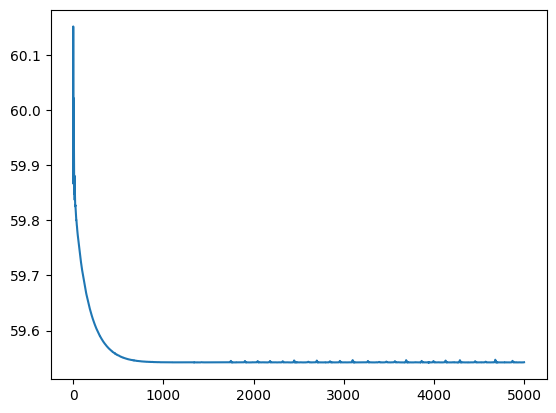

In [16]:
optimizer = torch.optim.Adam([*list(mlp.parameters()), log_var_noise, m0, s0], lr=0.01)
losses = []
pbar = tqdm(range(5000))
for i in pbar:
    optimizer.zero_grad()
    loss = neg_log_likelihood(x, y, m0, s0)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

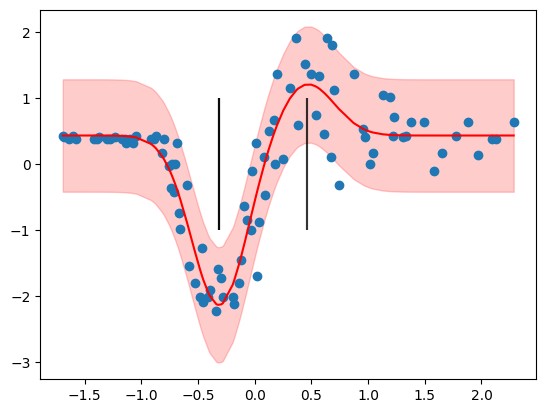

In [17]:
mn, sn = get_mn_sn(x, s0)
pred_mean, pred_var = get_pred_post(sn, mn, x)

fig, ax = plt.subplots()
ax = plot_preds_and_95(ax, x, pred_mean, pred_var)
with torch.no_grad():
    ax.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())
    ax.vlines(mlp.grid.cpu().numpy(), -1, 1, color="black", alpha=0.2)
plt.show()
